In [1]:
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set()
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"axes.facecolor": ".995",
                            'axes.spines.left': False,
                            'axes.spines.top': False,
                            'axes.spines.right': False,
                            'axes.edgecolor': '.5',
                            'axes.grid': True,
                            'grid.color': '.85'})

plt.rcParams["figure.figsize"] = [6.4, 4.8]

plt.rcParams["lines.linewidth"] = 2

plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.markeredgecolor"] = "w"
plt.rcParams["lines.markeredgewidth"] = "2"
plt.rcParams["lines.markersize"] = 6
palette = "Blues_d"

In [4]:
def utils_plot(log, title, ylim, show):
    plt.title(title + (" [log]" if log else ""))
    plt.ylim(0 if (ylim==None and not log) else (1 if ylim==None else ylim))
    plt.yscale("log" if log else "linear")
    if log:
        plt.grid(axis="y", which="both")
    
    if show:
        plt.show()

def plot_line(x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None, m2=True, show=True, size=None, color=None):
    if size is not None:
        plt.figure(figsize=size)
    
    if x2 is not None and y2 is not None:
        sns.lineplot(x2, y2, color=("lightblue" if m2 else "orange"), marker=(plt.rcParams["lines.marker"] if m2 else ""))
    if len(x) and len(y):
        sns.lineplot(x, y, color=("b" if not color else color))
    
    plt.xticks(xticks)
    utils_plot(log, title, ylim, show)

def plot_bar_m(x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None, width=None, show=True, size=None):
    if size is not None:
        plt.figure(figsize=size)
    
    if not x2 is None and not y2 is None:
        plt.bar(x2, y2, color="lightblue", width=(width[1] if len(width)>1 else width[0]))
    if len(x) and len(y):
        plt.bar(x, y, color="b", width=width[0])
    
    plt.xticks(xticks)
    utils_plot(log, title, ylim, show)

def plot_bar(x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None, show=True, size=None):
    if size is not None:
        plt.figure(figsize=size)
    
    if not x2 is None and not y2 is None:
        sns.lineplot(x2, y2, color="orange", marker="")
    if len(x) and len(y):
        sns.barplot(x, y, color="b", palette=palette)
    
    utils_plot(log, title, ylim, show)

%%latex
\newpage

# Podatki

Vir 1: NIJZ *\[[Spremljanje koronavirusa SARS-CoV-2 (COVID-19)](https://www.nijz.si/sl/pojav-novega-koronavirusa-2019-ncov)\]*  
Vir 2: prirejeno po NIJZ: *\[[Dnevno spremljanje okužb s SARS-CoV-2 (COVID-19) [graf]](https://www.nijz.si/sl/dnevno-spremljanje-okuzb-s-sars-cov-2-covid-19)\]*  
Vir 3: Objave vlade na [gov.si](https://www.gov.si/teme/koronavirus/) in [twitterju](https://twitter.com/vladaRS).

Na grafih je *vir 2* temno moder, *vir 1* svetlo moder, *vir 3* pa siv.

- pri *vir 1* so podatki na začetku za ob 14h, od dneva 11 naprej ob ~10-14h na določen dan, zato so na grafu zamaknjeni za 0.5 dneva v levo  
- pri *vir 2* so podatki na začetku za konec dneva, od dneva 15 naprej naslednji dan ob 10h  

Dan 1 je *4.3.*, zadnjič posodobljeno *21.3.* (zadnji celodnevni podatek velja za en dan nazaj).

### Podatki o okuženih

In [5]:
podatki_okuzeni = [
 [1, 1, 1],
 [2, 4, 6],
 [3, 8, 9],
 [4, 12, 13],
 [5, 16, 19],
 [6, 23, 29],
 [7, 31, 47],
 [8, 57, 77],
 [9, 89, 127],
 [10, 141, 174],
 [11, 181, 215],
 [12, 219, 247],
 [13, 253, 272],
 [14, 275, 283],
 [15, 286, 317],
 [16, 319, 341],
 [17, 341, 379],
 [18, 383, -1]] # ali 385 (tw, 17h)

#vir1 - Na začetku ob 14h, od dneva 11 naprej ob ~10h
dniS = np.array([d[0] for d in podatki_okuzeni])
okuzeniS = np.array([d[1] for d in podatki_okuzeni])

#vir2 - Konec dneva, od dneva 15 naprej naslednji dan ob 10h
dni = np.array([d[0] for d in podatki_okuzeni[:-1]])
okuzeni = np.array([d[2] for d in podatki_okuzeni[:-1]])

In [6]:
novi = np.array([okuzeni[0]] + [okuzeni[i+1] - okuzeni[i] for i in range(okuzeni.shape[0] - 1)])
noviS = np.array([okuzeniS[0]] + [okuzeniS[i+1] - okuzeniS[i] for i in range(okuzeniS.shape[0] - 1)])

In [7]:
rast = np.array([okuzeni[i+1]/okuzeni[i] for i in range(okuzeni.shape[0] - 1)])
podvojitev = math.log(2)/np.log(rast)

### Podatki o testih

In [82]:
diff = 313 # št. testiranih pred dnem 1
podatki_testirani = [
 [-3, 183, 183],
 [-2, 208, 208],
 [-1, 255, 255],
 [0, 290, 313],
 [1, 352, 364],
 [2, 433, 467],
 [3, 498, 745],
 [4, 785, 922],
 [5, 981, 1160],
 [6, 1227, 1527],
 [7, 1643, 2069],
 [8, 2270, 2818],
 [9, 3058, 3863],
 [10, 4346, 5060],
 [11, 5369, 5976],
 [12, 6156, 6566],
 [13, 6712, 7437],
 [14, 7587, 8558],
 [15, 8730, 9584],
 [16, 9860, 10732],
 [17, 10980, 11940],
 [18, 12250, -1]]

#Ker v tej tabeli desni stolpec pomeni okužbe ob koncu dneva in ne naslednji dan ob 10h kot za okužene
# za računanje razmerij med okuženimi in testi uporabljam namesto zadnje vrednosti v njem spodnjo
drugacen_zadnji_testi = 12162

#vir1 - Na začetku ob 14h, od dneva 11 naprej enkrat med 10h in 14h. Nekateri dnevi manjkajo
dni_testS = np.array([d[0] for d in podatki_testirani if d[1]>0])
testiraniS = np.array([d[1] for d in podatki_testirani if d[1]>0])

#vir2 - Konec dneva, zadnji dan vključuje še teste naslednjega dne do enkrat med 10h in 14h
dni_test = np.array([d[0] for d in podatki_testirani[:-1]])
testirani = np.array([d[2] for d in podatki_testirani[:-1]])
testirani_drug_z = np.array([d[2] for d in podatki_testirani[:-2]] + [drugacen_zadnji_testi])

#d = [[dni_testS[i], testiraniS[i]] for i in range(len(dni_testS))]

In [83]:
novi_testi = np.array([(testirani[i+1] - testirani[i])/(dni_test[i+1] - dni_test[i]) 
                       for i in range(dni_test.shape[0] - 1)])
novi_testi_drug_z = np.array([(testirani_drug_z[i+1] - testirani_drug_z[i])/(dni_test[i+1] - dni_test[i]) 
                       for i in range(dni_test.shape[0] - 1)])

novi_testiS = np.array([(testiraniS[i+1] - testiraniS[i])/(dni_testS[i+1] - dni_testS[i]) 
                       for i in range(dni_testS.shape[0] - 1)])

### Razmerja med testi in okuženimi

In [84]:
dni_odstotek = np.array([i for i in dni_test if i >= 0])

# Odstotek pozitivnih skupaj in za posamezen dan
odstotek_poz = np.array([0] + [okuzeni[i]/testirani_drug_z[i+4] for i in range(len(dni))])
odstotek_poz_novi = np.array([0] + [novi[i]/novi_testi_drug_z[i+3] for i in range(len(dni))])

# Testi na posameznega okuženega
testi_na_okuzenega = np.array([testirani_drug_z[i+4]/okuzeni[i] for i in range(len(dni))])
novi_testi_na_okuzenega = np.array([novi_testi_drug_z[i+3]/okuzeni[i] for i in range(len(dni))])
novi_testi_na_novega = np.array([novi_testi_drug_z[i+3]/novi[i] for i in range(len(dni))])

### Dodatne informacije *(vir 3)*

In [85]:
podatki_ekstra = [
    [15, 36, 6], #20h, 8740testov, 286poz = 14h
    [16, 45, 6], #21h
    [17, 55, 9, 1046, 28], #17h +1046test +28poz
    [18, 56, 9, 1482, 44]  #14h 385poz (2+kot nijz)
]

dni_ekstra = np.array([d[0] for d in podatki_ekstra])
hospitalizirani = np.array([d[1] for d in podatki_ekstra])
intenzivni = np.array([d[2] for d in podatki_ekstra])

dni_ekstra2 = np.array([d[0] for d in podatki_ekstra if len(d)>3])
novi_ekstra = np.array([d[4] for d in podatki_ekstra if len(d)>3])
novi_testi_ekstra = np.array([d[3] for d in podatki_ekstra if len(d)>3])

-

In [86]:
dni2 = np.array([i for i in range(1, 22+1)])

---

%%latex
\newpage

## Primerjava virov

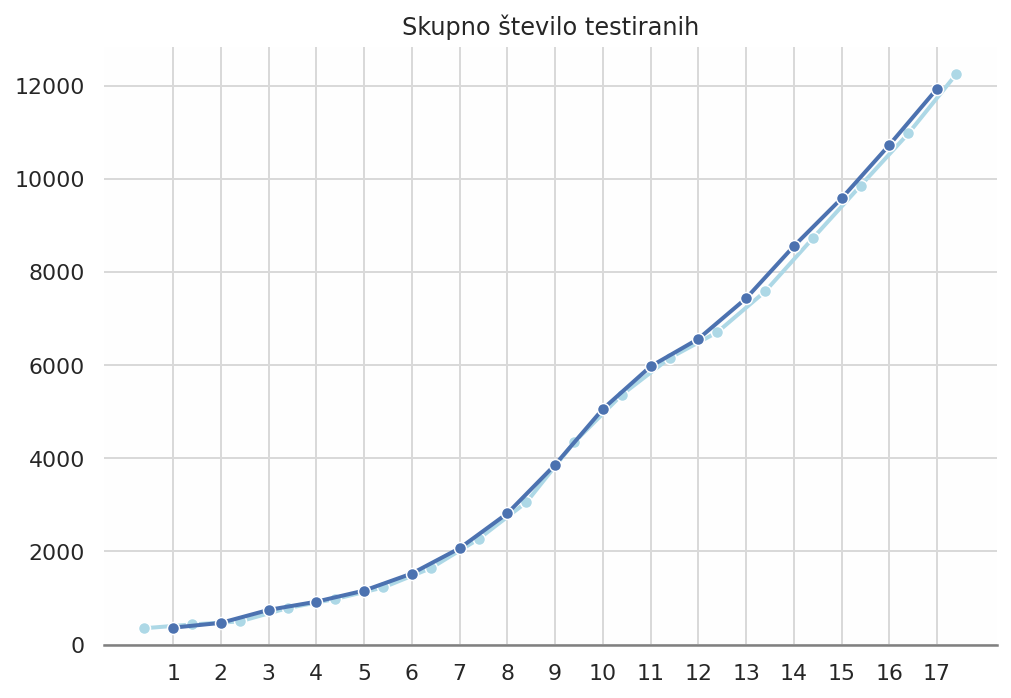

In [87]:
plot_line(dni_test[4:], testirani[4:], False, "Skupno število testiranih", xticks=dni,
          x2=dni_testS[4:] - 0.6, y2=testiraniS[4:], size=(8, 5.5))

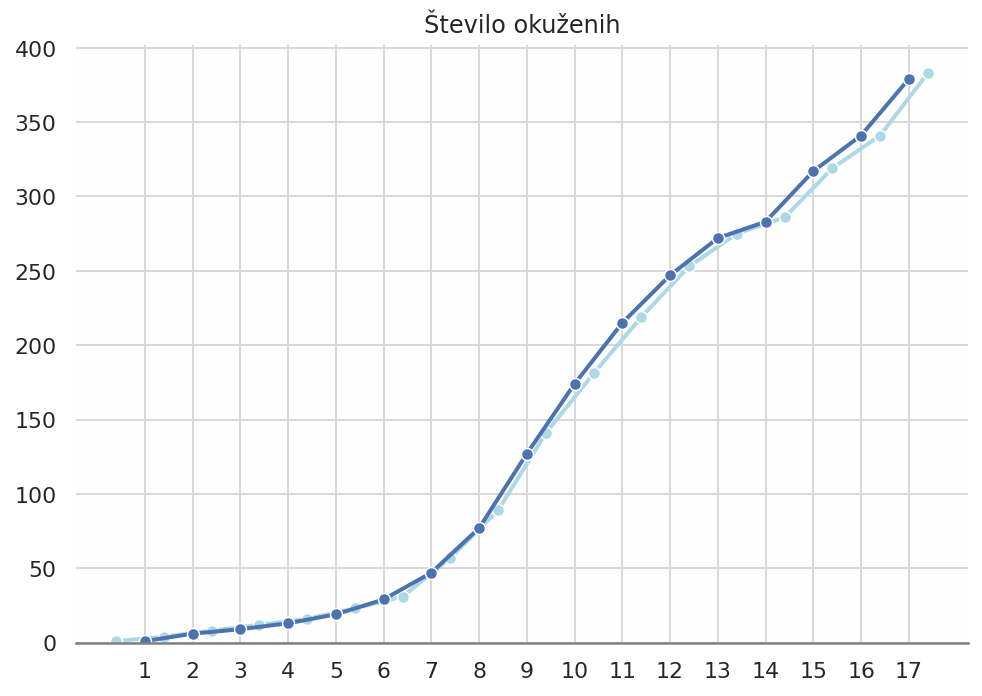

In [99]:
plot_line(dni, okuzeni, False, "Število okuženih", xticks=dni,
          x2=dniS - 0.6, y2=okuzeniS, size=(8, 5.5))

[]

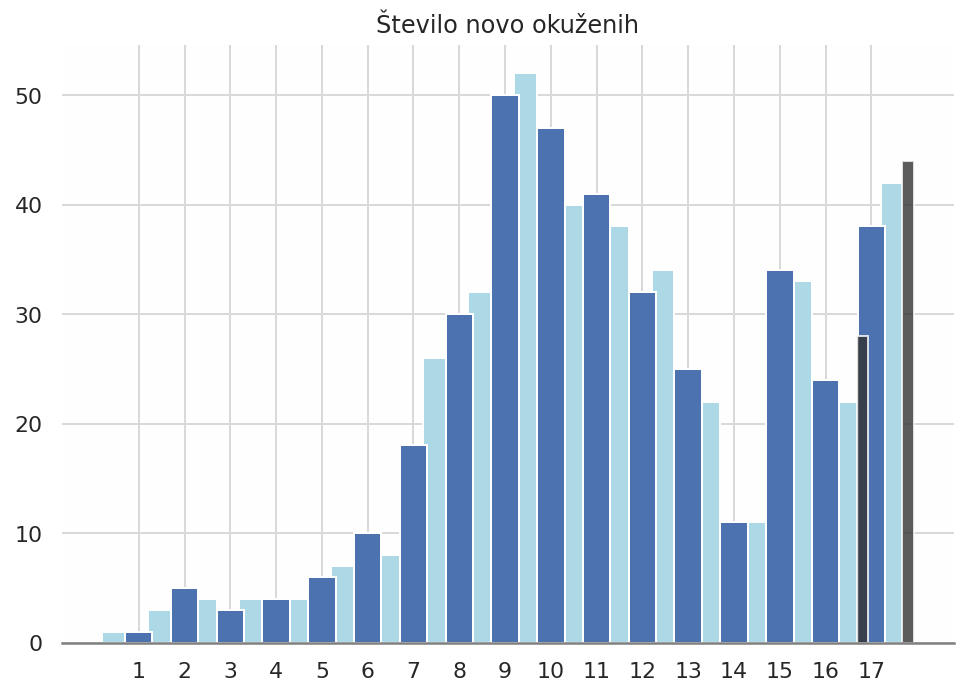

In [97]:
plot_bar_m(dni, novi, False, "Število novo okuženih", xticks=dni,
          x2=dniS - .55, y2=noviS, width=(0.6, 0.5), size=(8, 5.5), show=False)
plt.bar(dni_ekstra2-.2, novi_ekstra, width=0.25, color=".2", alpha=.8)
plt.plot()

[]

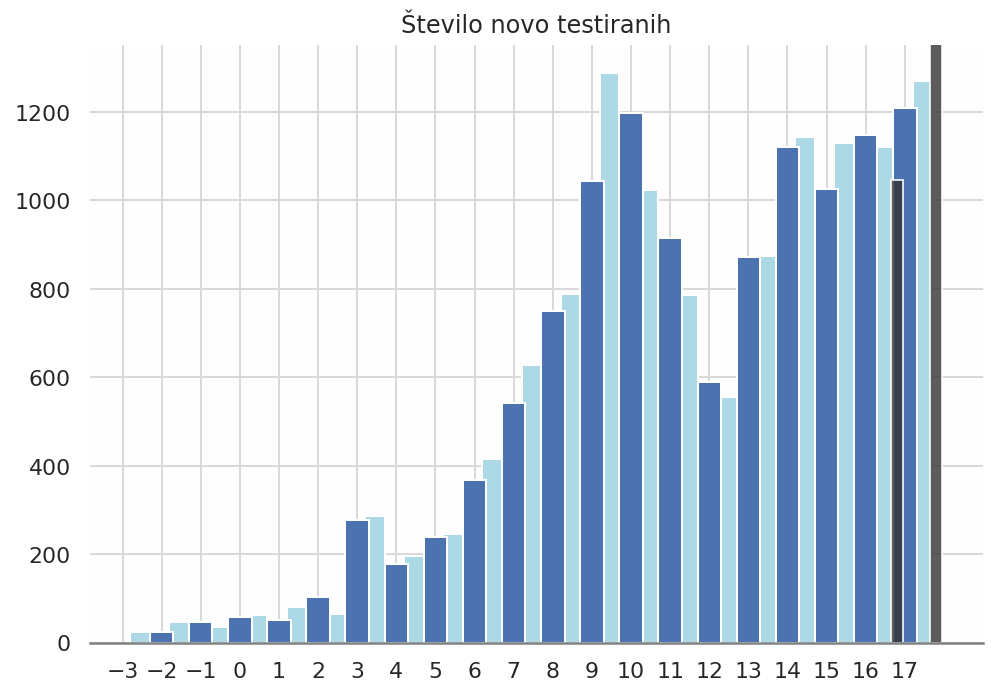

In [95]:
plot_bar_m(dni_test[1:], novi_testi, False, "Število novo testiranih", xticks=dni_test,
          x2=dni_testS[1:] - .55, y2=novi_testiS, width=(0.6, 0.5), size=(8, 5.5), show=False)
plt.bar(dni_ekstra2-.2, novi_testi_ekstra, width=0.3, color=".2", alpha=.8)
plt.plot()

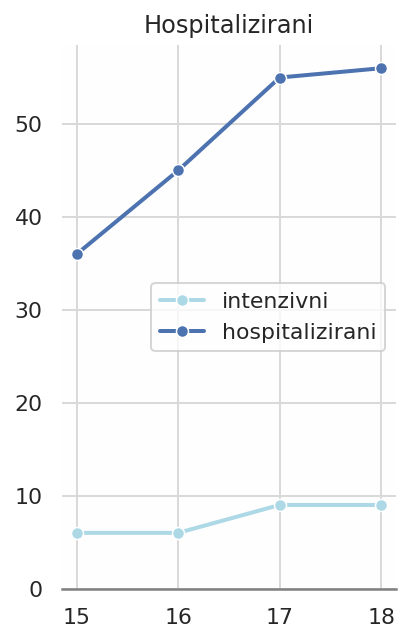

In [109]:
plot_line(dni_ekstra, hospitalizirani, False, "Hospitalizirani", xticks=dni_ekstra,
          x2=dni_ekstra, y2=intenzivni, size=(3, 5), show=False)
plt.legend(["hospitalizirani", "intenzivni"])
plt.show()

---

%%latex
\newpage

# Skupaj okuženih

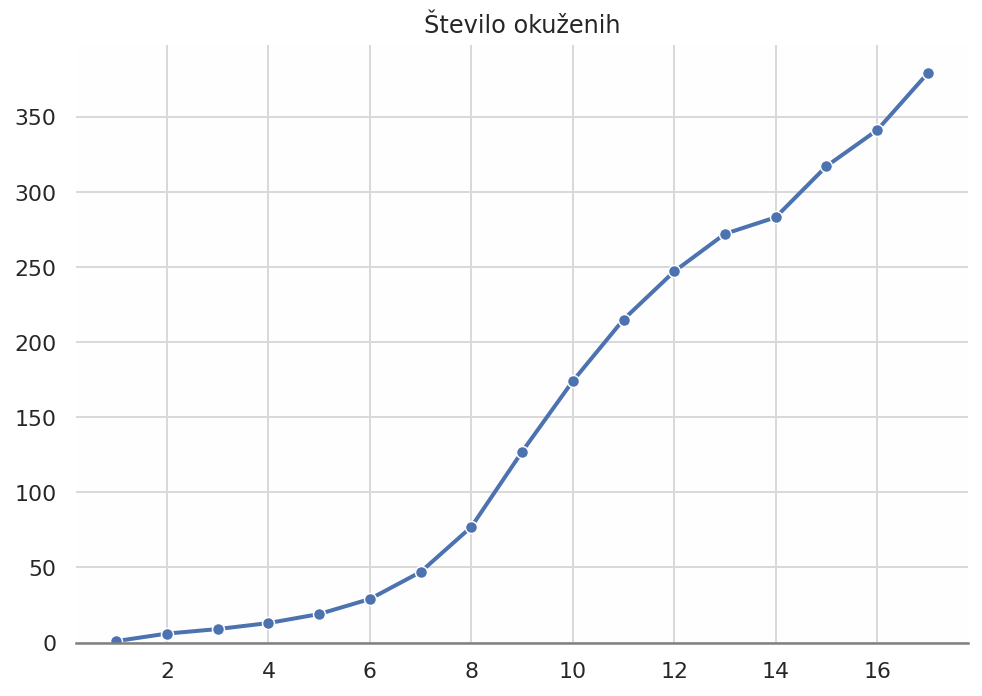

In [18]:
plot_line(dni, okuzeni, False, "Število okuženih", size=(8, 5.5))

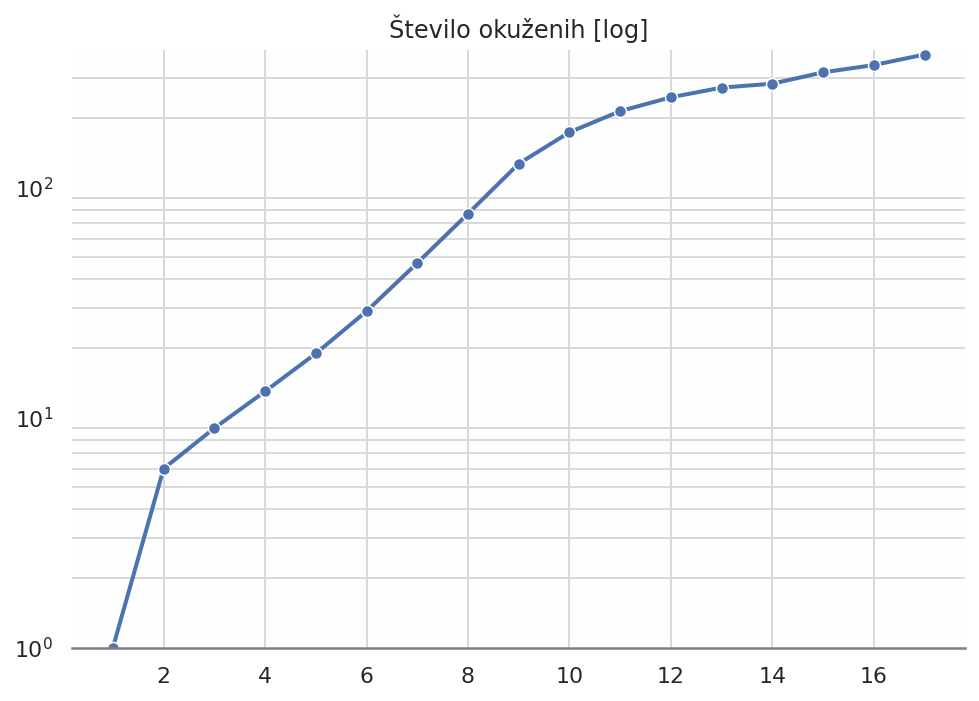

In [19]:
plot_line(dni, okuzeni, True, "Število okuženih", size=(8, 5.5))

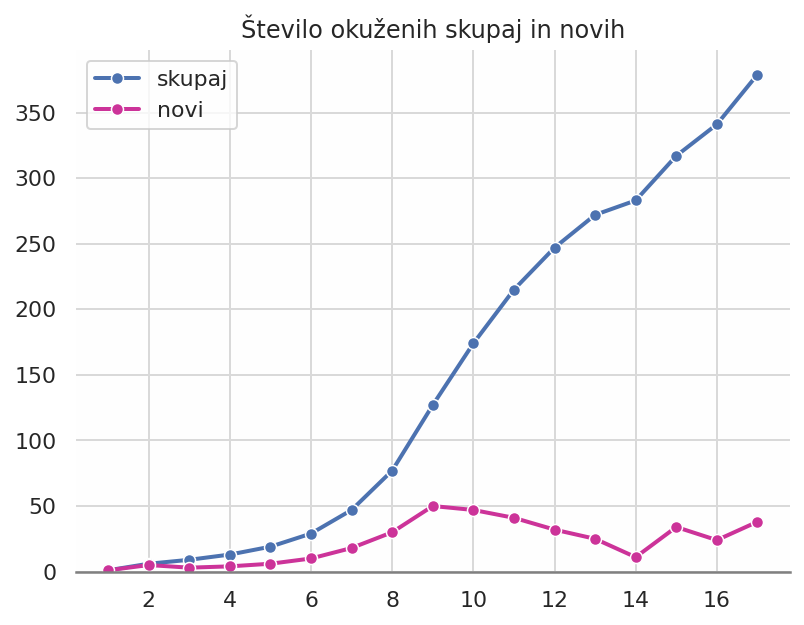

In [105]:
plot_line(dni, okuzeni, False, "", show=False)
plot_line(dni, novi, False, "Število okuženih skupaj in novih", size=None, color="#C39", show=False)
plt.legend(["skupaj", "novi"])
plt.show()

---

%%latex
\newpage

## Iskanje prilegajoče eksponentne funkcije

$$ f(x) = a^{x - b} $$

In [21]:
def eksp(x, a, b):
    return a**(x-b)

In [22]:
apr, pcov = scipy.optimize.curve_fit(eksp, dni, okuzeni)
a, b = apr

Najdeni paremetri funkcije:

In [23]:
print("a = %.2f\nb = %.2f\n\nf(x) = %.2f ^ (x - (%.2f))" % (a, b, a, b))

a = 1.17
b = -20.74

f(x) = 1.17 ^ (x - (-20.74))


In [24]:
preds = eksp(dni, a, b)

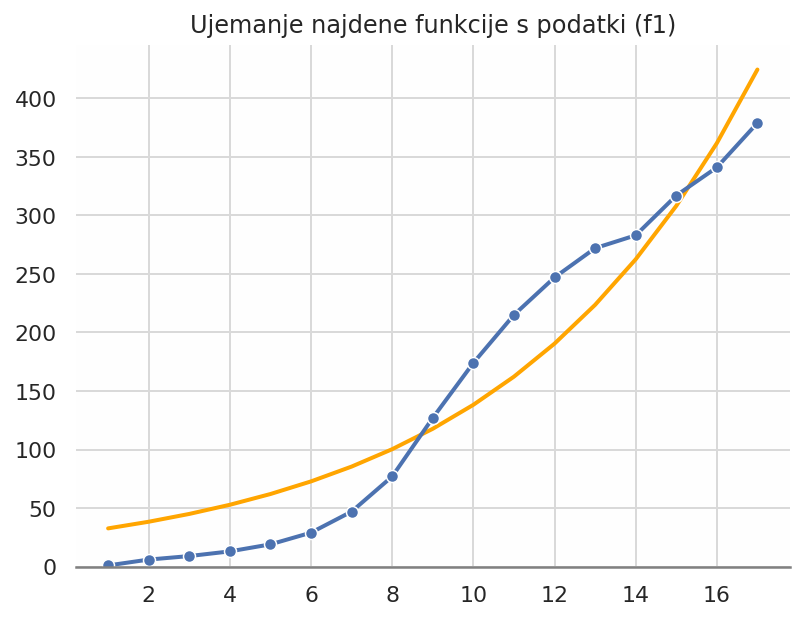

In [25]:
plot_line(dni, okuzeni, False, "Ujemanje najdene funkcije s podatki (f1)",
         x2=dni, y2=preds, m2=False)

### Napoved za naprej

**Čas podovijitve** števila okuženih:

In [26]:
dbl1 = math.log(2)/math.log(a)
print("Št. okuženih se podvoji na %.1f dni." % dbl1)

Št. okuženih se podvoji na 4.3 dni.


In [27]:
preds2 = eksp(dni2, a, b)

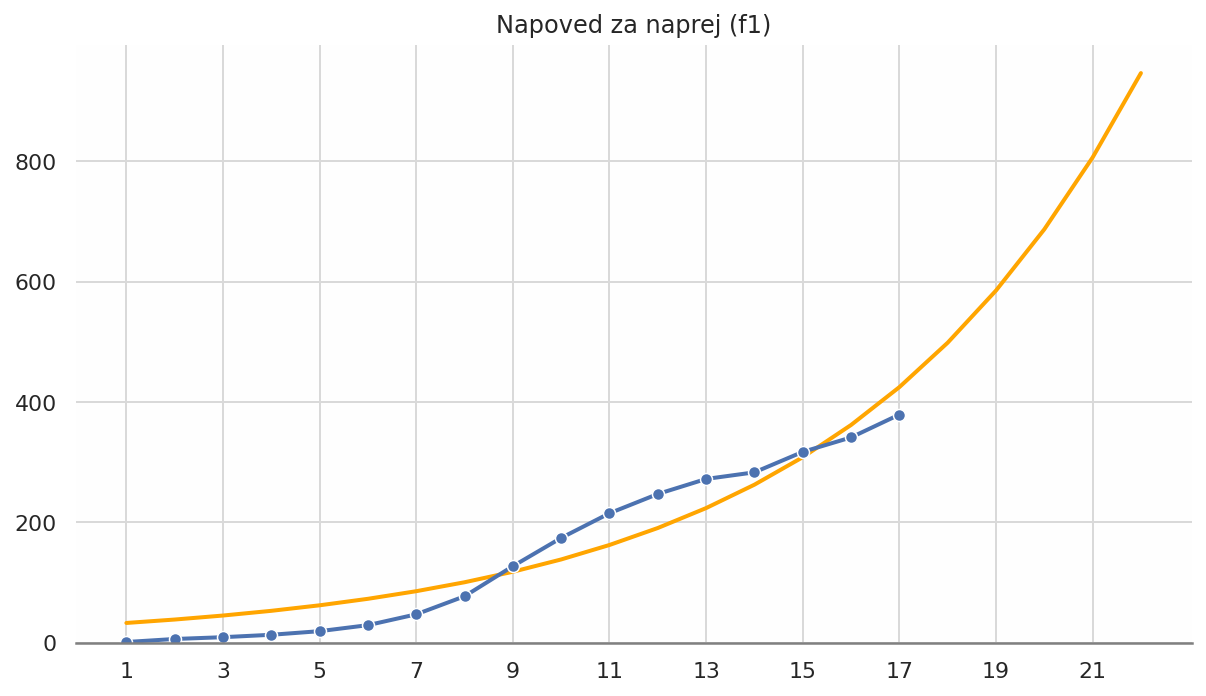

In [28]:
plot_line(dni, okuzeni, False, "Napoved za naprej (f1)", xticks=dni2[::2],
         x2=dni2, y2=preds2, m2=False, size=(10,5.5))

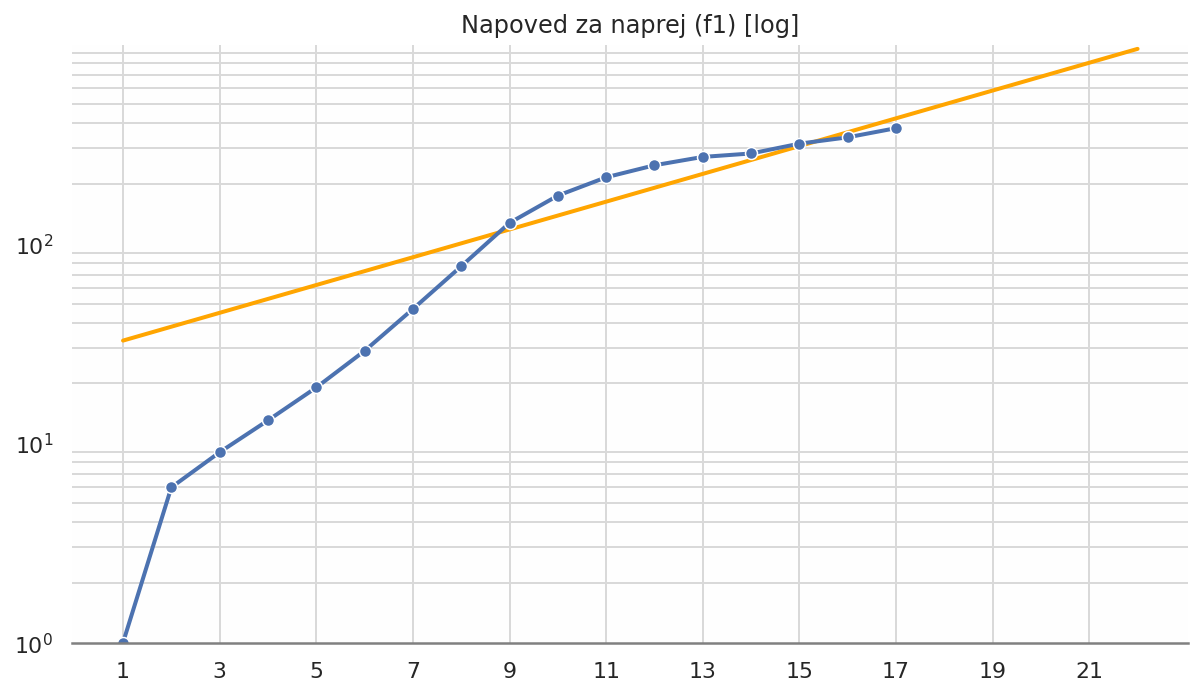

In [29]:
plot_line(dni, okuzeni, True, "Napoved za naprej (f1)", xticks=dni2[::2],
         x2=dni2, y2=preds2, m2=False, size=(10,5.5))

%%latex
\newpage

## Iskanje prilegajoče linearne funkcije na logaritmiranih podatkih

In [30]:
okuzeni_log = np.log(okuzeni)/np.log(10)

$$ f(x) = k * x + n $$

In [31]:
def lin(x, k, n):
    return k*x + n

In [32]:
# Prva dva dneva se zaradi odstopanja ne upošteva
apr1, pcov1 = scipy.optimize.curve_fit(lin, dni[2:], okuzeni_log[2:])
k, n = apr1

a1 = np.exp(k*np.log(10))
b1 = -np.exp((n)*np.log(10))

Najdeni parametri linearne funkcije:

In [33]:
print("k = %.2f\nn = %.2f\n\nf(x) = %.2f * x + %.2f" % (k, n, k, n))

k = 0.12
n = 0.80

f(x) = 0.12 * x + 0.80


Pretvorjeno v eksponentno funkcijo z linearno skalo:

In [34]:
print("a = %.2f\nb = %.2f\n\nf(x) = %.2f ^ (x - (%.2f))" % (a1, b1, a1, b1))

a = 1.32
b = -6.31

f(x) = 1.32 ^ (x - (-6.31))


In [35]:
preds1 = lin(dni, k, n)
preds1e = np.exp(preds1*np.log(10))

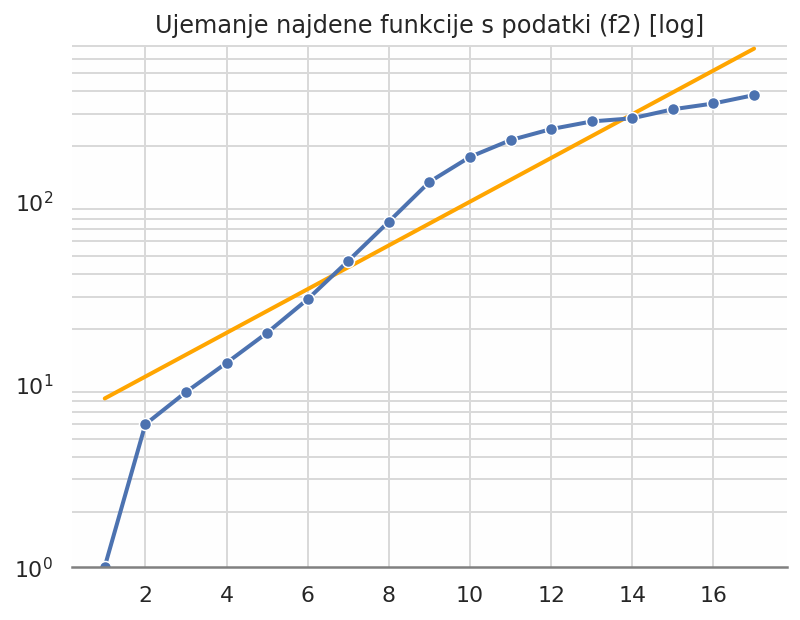

In [36]:
plot_line(dni, okuzeni, True, "Ujemanje najdene funkcije s podatki (f2)",
         x2=dni, y2=preds1e, m2=False)

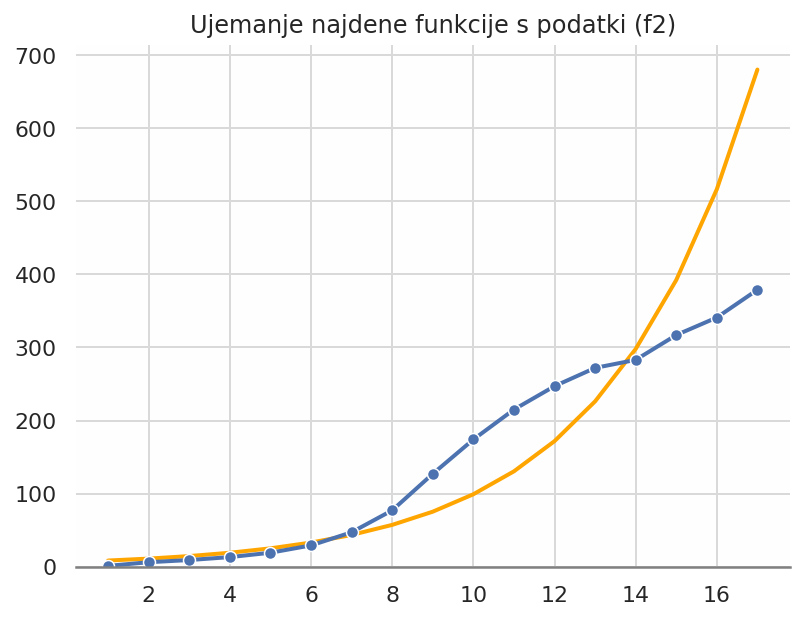

In [37]:
plot_line(dni, okuzeni, False, "Ujemanje najdene funkcije s podatki (f2)",
         x2=dni, y2=preds1e, m2=False)

### Napoved za naprej

**Čas podovijitve** števila okuženih:

In [38]:
dbl2 = math.log(2)/math.log(a1)
print("Št. okuženih se podvoji na %.1f dni." % dbl2)

Št. okuženih se podvoji na 2.5 dni.


In [39]:
preds12 = lin(dni2, k, n)
preds12e = np.exp(preds12*np.log(10))

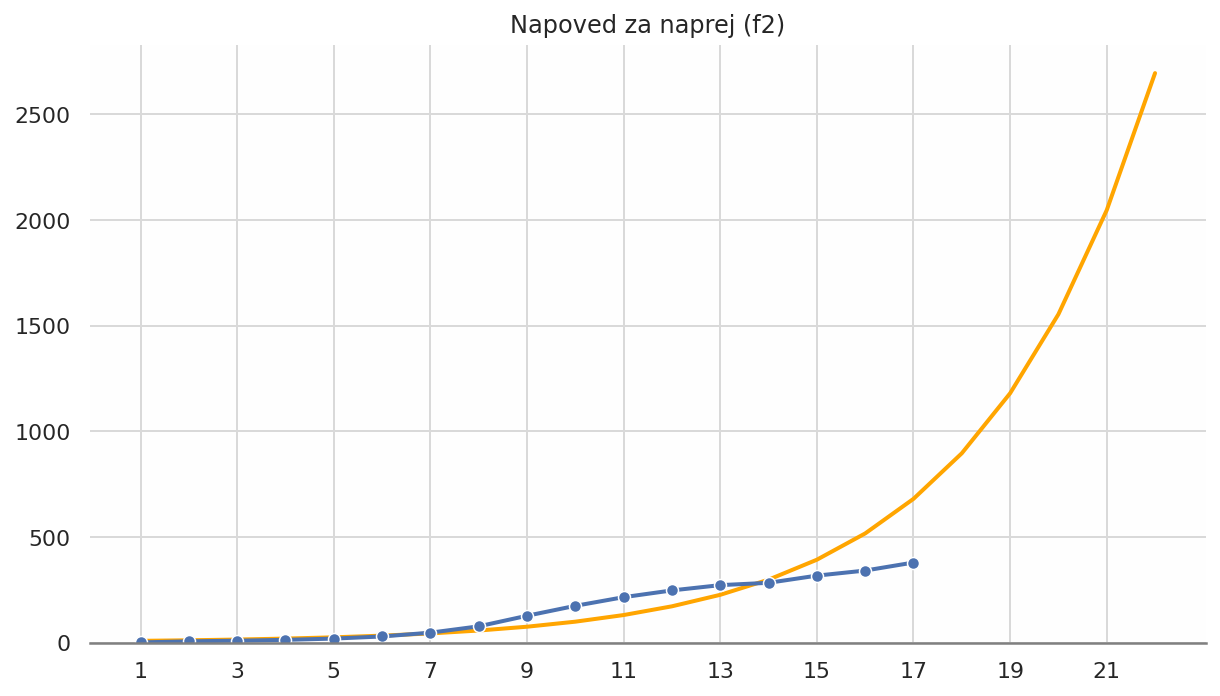

In [40]:
plot_line(dni, okuzeni, False, "Napoved za naprej (f2)", xticks=dni2[::2],
         x2=dni2, y2=preds12e, m2=False, size=(10,5.5))

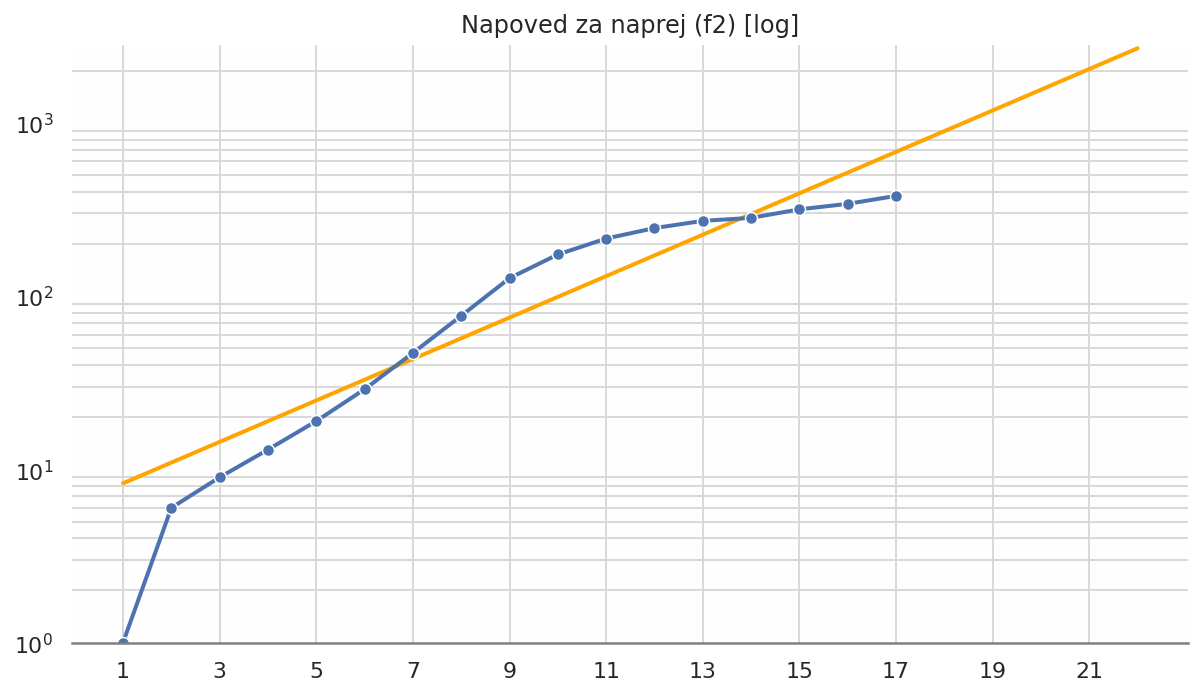

In [41]:
plot_line(dni, okuzeni, True, "Napoved za naprej (f2)", xticks=dni2[::2],
         x2=dni2, y2=preds12e, m2=False, size=(10,5.5))

---

%%latex
\newpage

# Novi okuženi

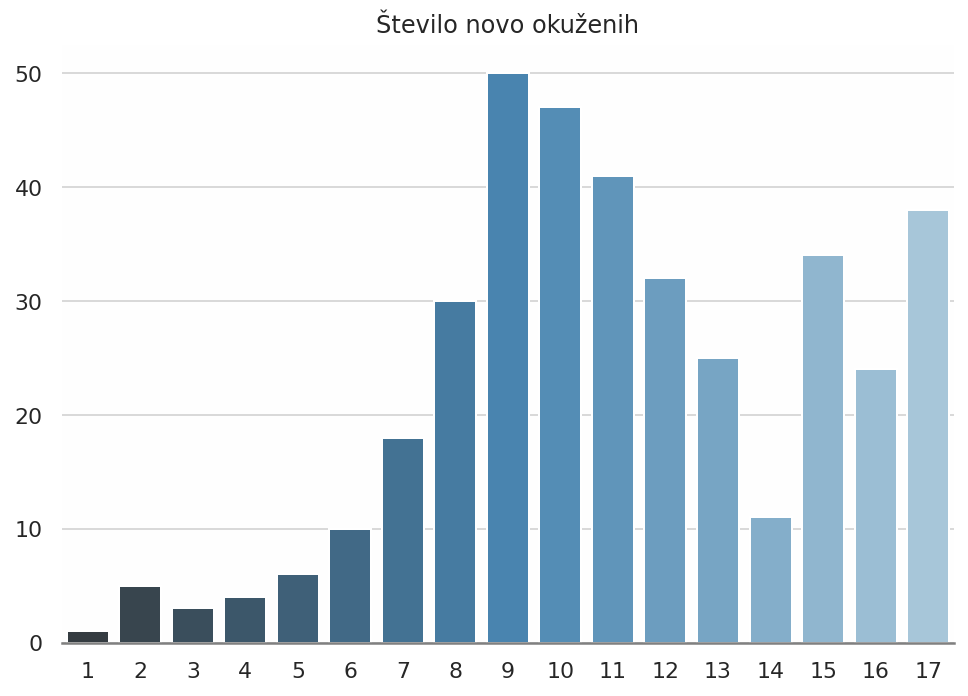

In [42]:
plot_bar(dni, novi, False, "Število novo okuženih", size=(8, 5.5))

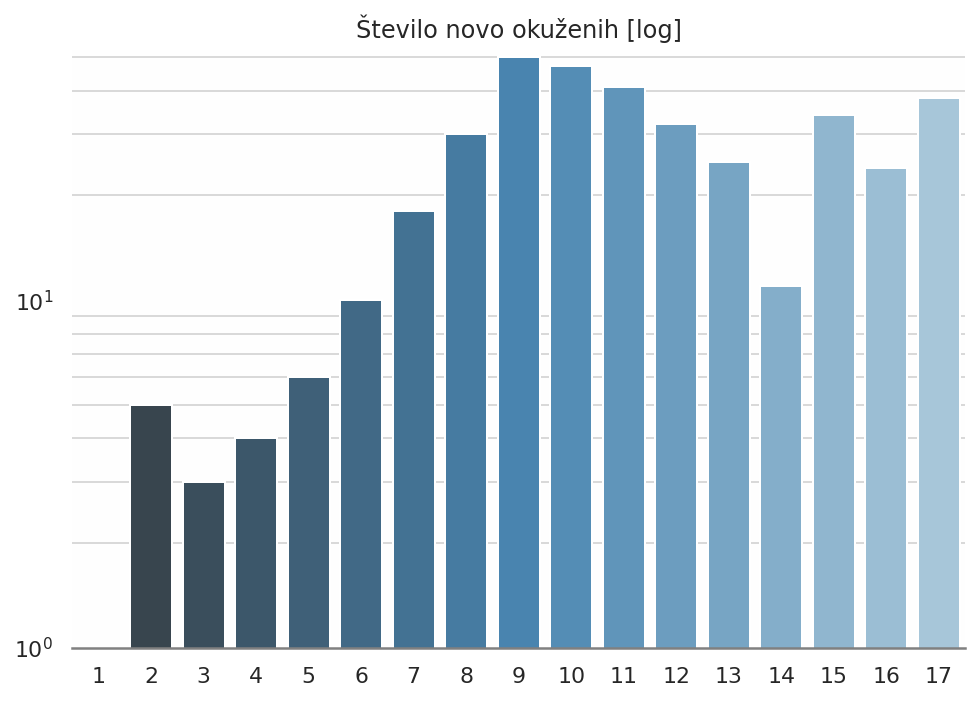

In [43]:
plot_bar(dni, novi, True, "Število novo okuženih", size=(8, 5.5))

%%latex
\newpage

## Faktor dnevne rasti

*Kolikokrat* več okuženih je nek dan glede na prejšnjega

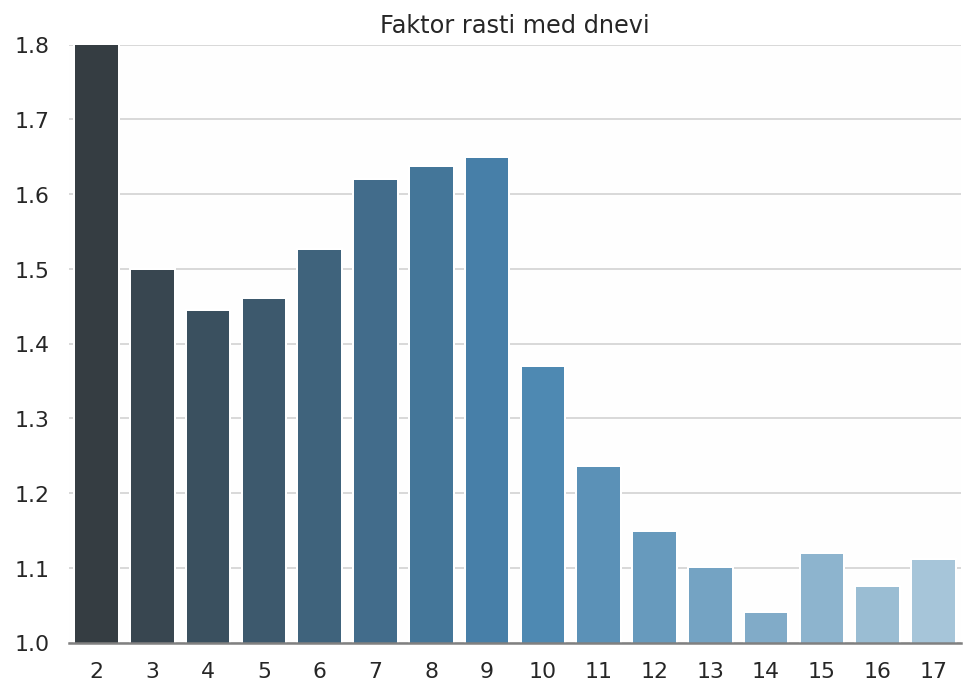

In [44]:
plot_bar(dni[1:], rast, False, "Faktor rasti med dnevi", ylim=(1,1.8), size=(8, 5.5))

**Povprečni faktor dnevne rasti** zadnjih 3 dni:

In [45]:
print("%.2f" % np.average(rast[-3:]))

1.10


### Čas podvojitve števila okuženih

$$ časPodvojitve = \frac{ln(2)}{ln(faktorRasti)} $$

**Čas podvojitve** števila okuženih *glede na faktor rasti zadnjega dne* in *povprečja zadnjih dveh dni*:

In [46]:
dbl_d2 = math.log(2)/math.log(np.average(rast[-2:]))
print("Št. okuženih se bo podvojila čez %.1f dni (glede na zadnja dva dneva)" % dbl_d2)

dbl_d1 = math.log(2)/math.log(rast[-1])
print("Št. okuženih se bo podvojila čez %.1f dni (glede na zadnji dan)" % dbl_d1)

Št. okuženih se bo podvojila čez 7.7 dni (glede na zadnja dva dneva)
Št. okuženih se bo podvojila čez 6.6 dni (glede na zadnji dan)


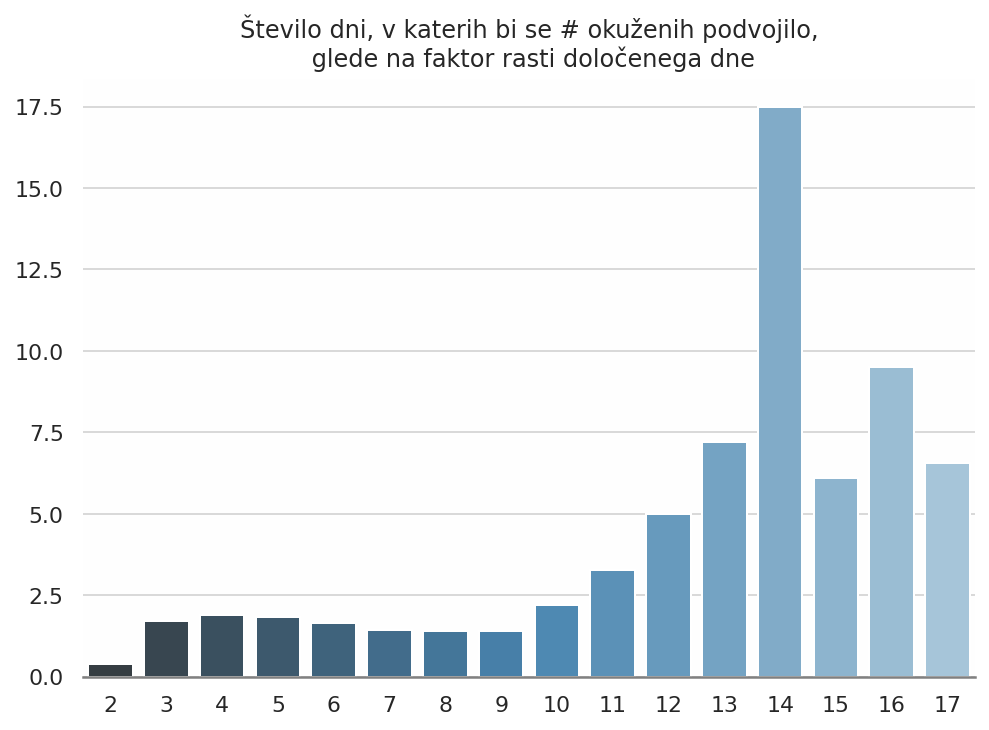

In [47]:
plot_bar(dni[1:], podvojitev, False, 
         "Število dni, v katerih bi se # okuženih podvojilo,\n glede na faktor rasti določenega dne",
         size=(8, 5.5))

%%latex
\newpage

## Iskanje prilegajoče funkcije novih primerov na logaritmiranih podatkih

In [48]:
novi_log = np.log(novi)/np.log(10)

In [49]:
# Prva dva dni se zaradi odstopanja ne upošteva
apr1n, pcov1n = scipy.optimize.curve_fit(lin, dni[2:], novi_log[2:])
kn, nn = apr1n

a1n = np.exp(kn*np.log(10))
b1n = -np.exp(nn*np.log(10))

Najdeni parametri linearne funkcije:

In [50]:
print("k = %.2f\nn = %.2f\n\nf(x) = %.2f * x + %.2f" % (kn, nn, kn, nn))

k = 0.06
n = 0.67

f(x) = 0.06 * x + 0.67


Pretvorjeno v eksponentno funkcijo z linearno skalo:

In [51]:
print("a = %.2f\nb = %.2f\n\nf(x) = %.2f ^ (x - (%.2f))" % (a1n, b1n, a1n, b1n))

a = 1.15
b = -4.68

f(x) = 1.15 ^ (x - (-4.68))


### Ujemanje najdene funkcije s podatki

In [52]:
preds1 = lin(dni, kn, nn)
preds1e = np.exp(preds1*np.log(10))

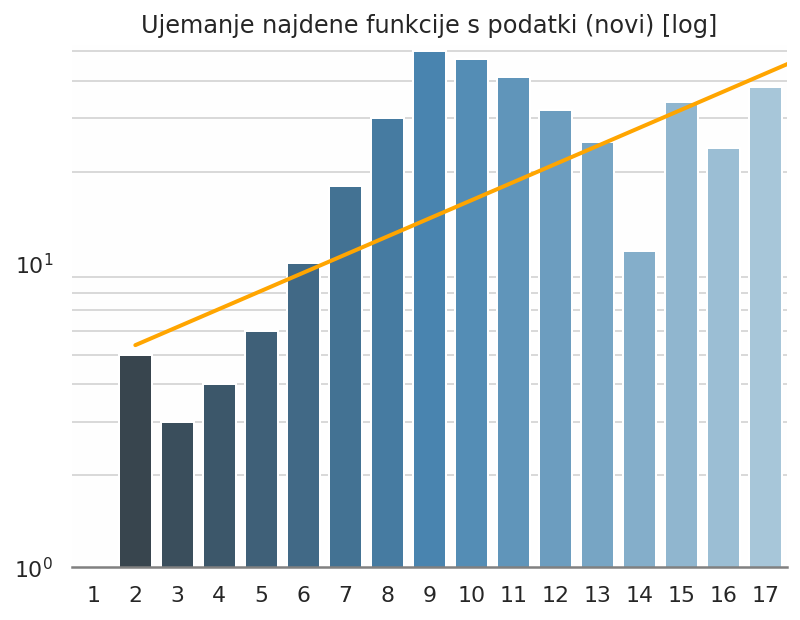

In [53]:
plot_bar(dni, novi, True, "Ujemanje najdene funkcije s podatki (novi)",
         x2=dni, y2=preds1e)

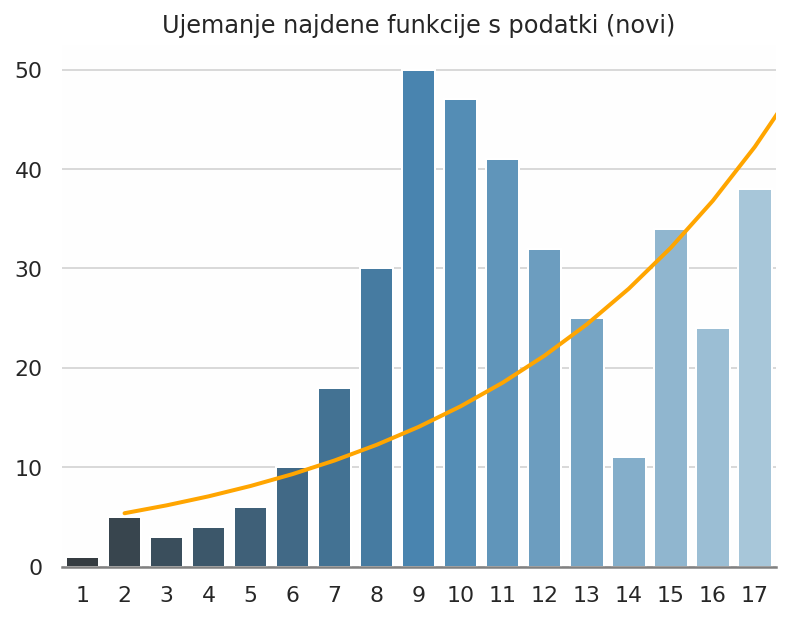

In [54]:
plot_bar(dni, novi, False, "Ujemanje najdene funkcije s podatki (novi)",
         x2=dni, y2=preds1e)

**Čas podovijitve** števila novo okuženih:

In [55]:
dbl3 = math.log(2)/math.log(a1n)
print("Št. novo okuženih se podvoji na %.1f dni." % dbl3)

Št. novo okuženih se podvoji na 5.0 dni.


---

%%latex
\newpage

# Testiranje

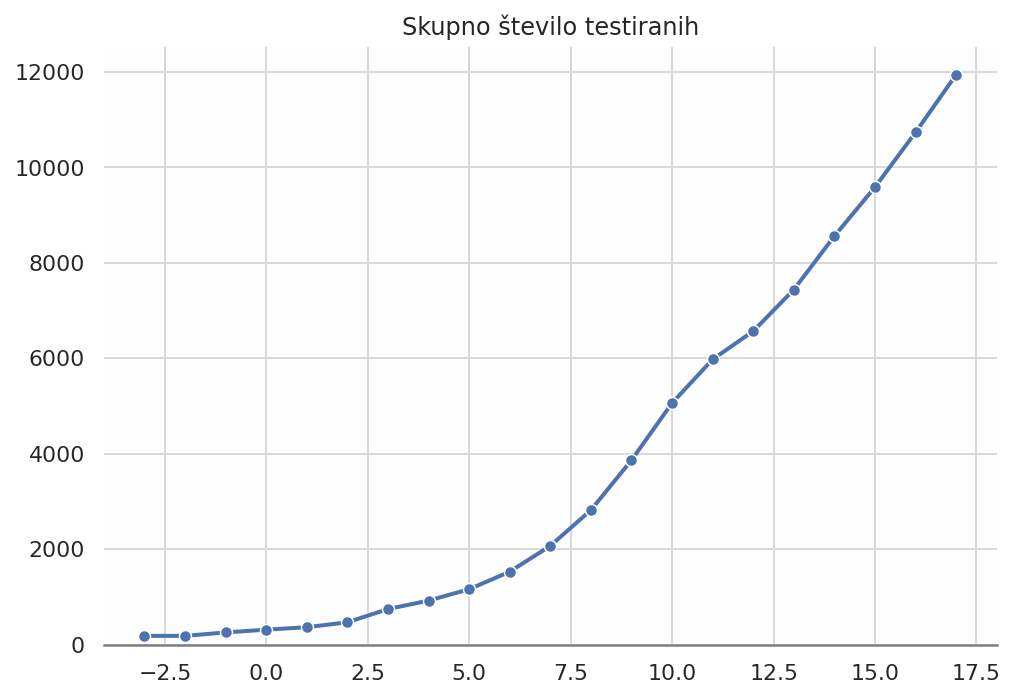

In [56]:
plot_line(dni_test, testirani, False, "Skupno število testiranih", size=(8, 5.5))

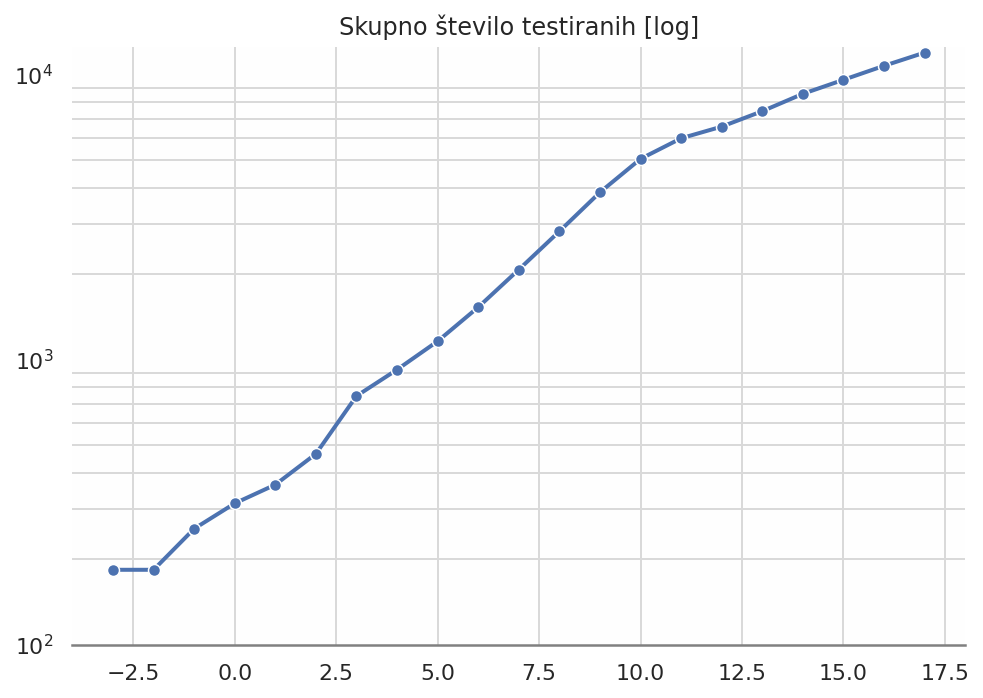

In [57]:
plot_line(dni_test, testirani, True, "Skupno število testiranih", ylim=100, size=(8, 5.5))

%%latex
\newpage

## Število novo testiranih

Za nekatere dni ni podatka o skupnem številu testiranih. Kjer je od prejšnjega podatka minilo več kot en dan, se razliko glede na prejšnjič deli s številom preteklih dni.  
Ne upošteva se prvega dne s podatkom o št. testov ker razporeditev po dnevih pred tem ni znana.

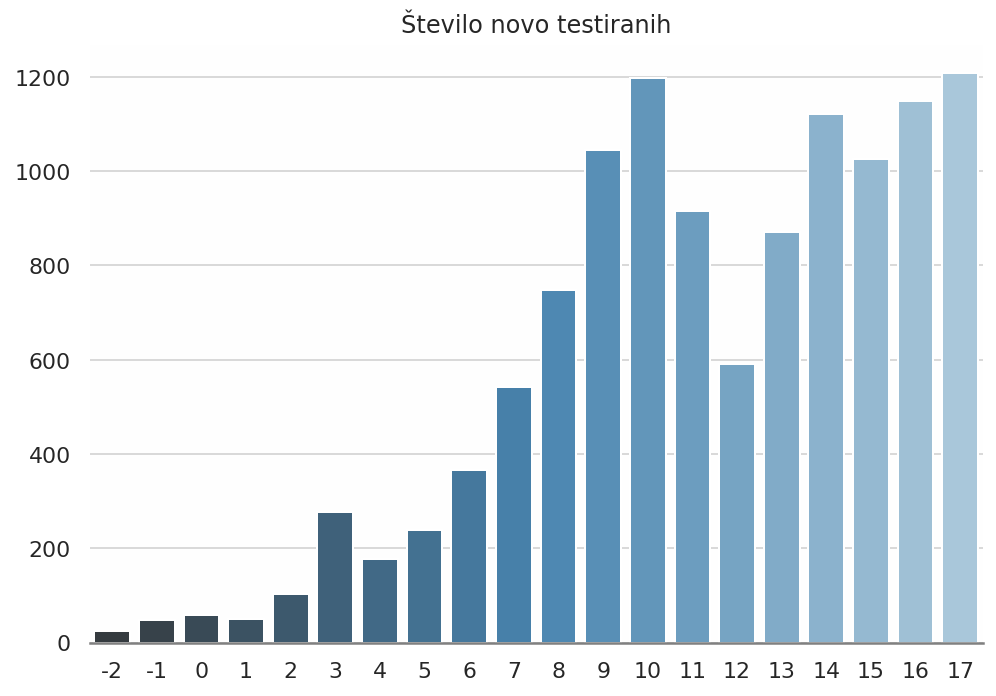

In [92]:
plot_bar(dni_test[1:], novi_testi, False, "Število novo testiranih", size=(8, 5.5))

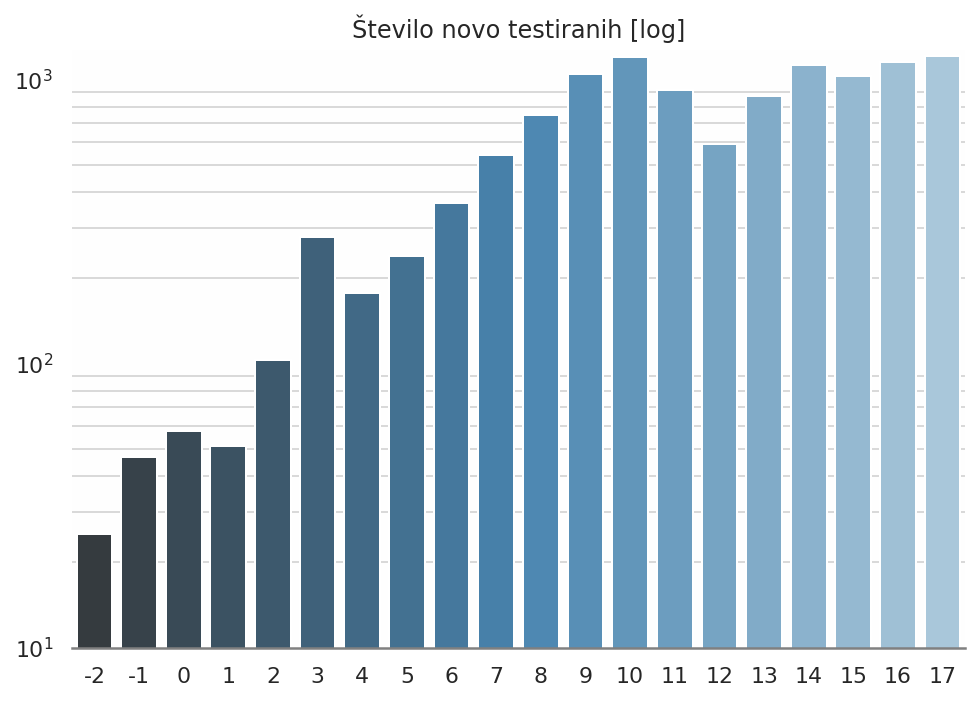

In [93]:
plot_bar(dni_test[1:], novi_testi, True, "Število novo testiranih", ylim=10, size=(8, 5.5))

%%latex
\newpage

## Odstotek pozitivnih testov

Kolikšen delež testov do vključno tistega dne je bilo pozitivnih (*št. okuženih / št. skupno testiranih*)

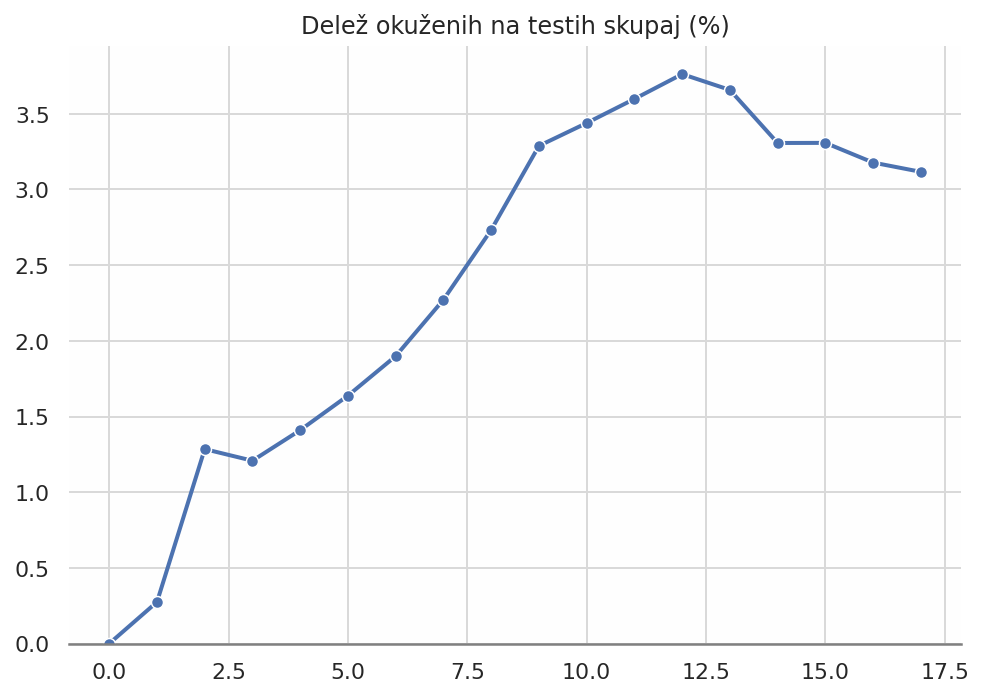

In [60]:
plot_line(dni_odstotek, odstotek_poz*100, False, "Delež okuženih na testih skupaj (%)", size=(8, 5.5))

In [61]:
print("Ocena okuženih v Sloveniji ob (napačni) predpostavki,\n da so testirani reprezentativen vzorec celotne populacije: "
     + str(int(odstotek_poz[-1]*2_000)*1000))

Ocena okuženih v Sloveniji ob (napačni) predpostavki,
 da so testirani reprezentativen vzorec celotne populacije: 62000


### Odstotek pozitivnih testov na določen dan

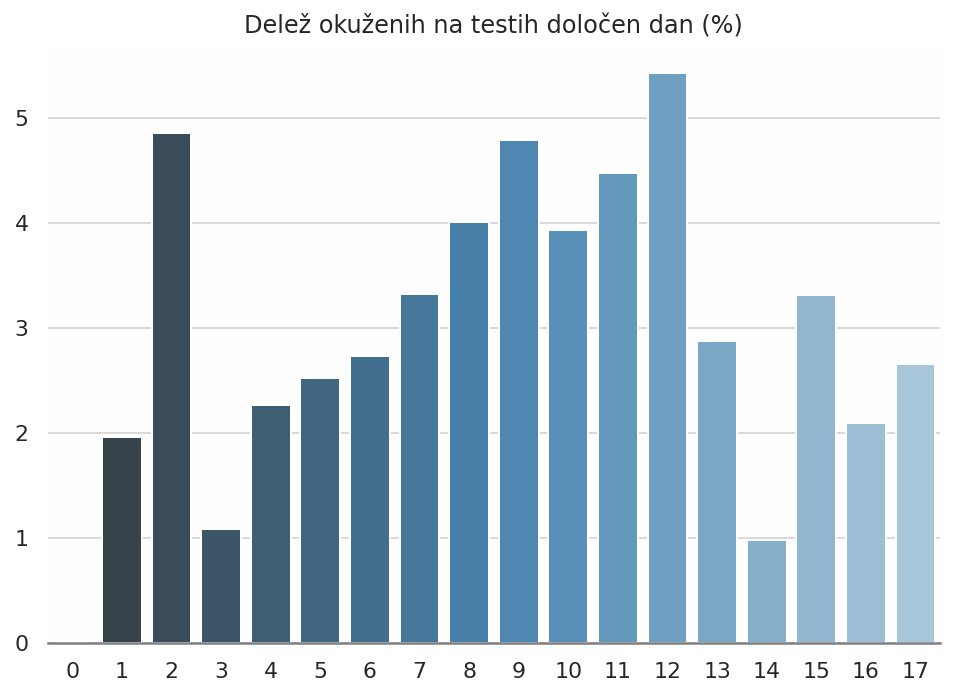

In [62]:
plot_bar(dni_odstotek, odstotek_poz_novi*100, False, "Delež okuženih na testih določen dan (%)", size=(8, 5.5))

## Testiranje glede na število okuženih

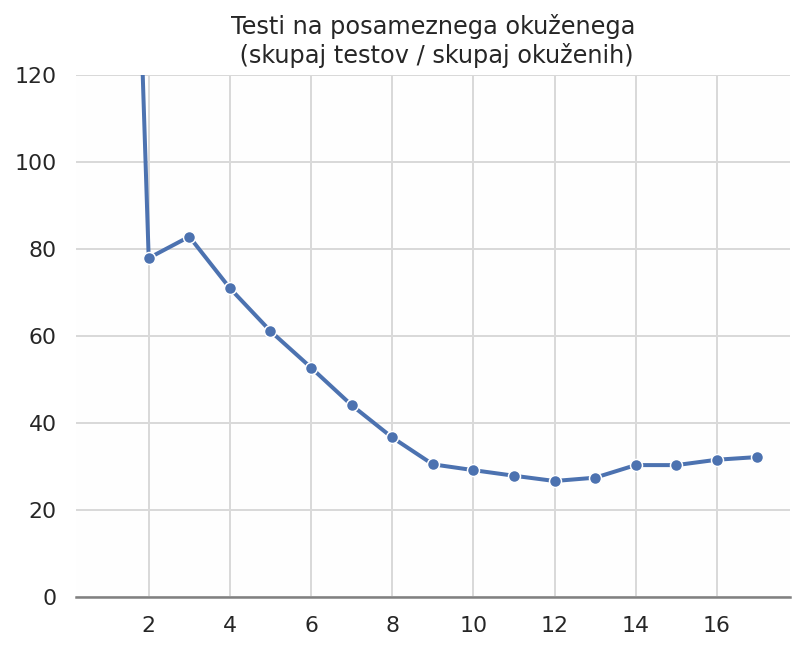

In [63]:
plot_line(dni, testi_na_okuzenega, False, "Testi na posameznega okuženega\n (skupaj testov / skupaj okuženih)",
          ylim=(0, 120))

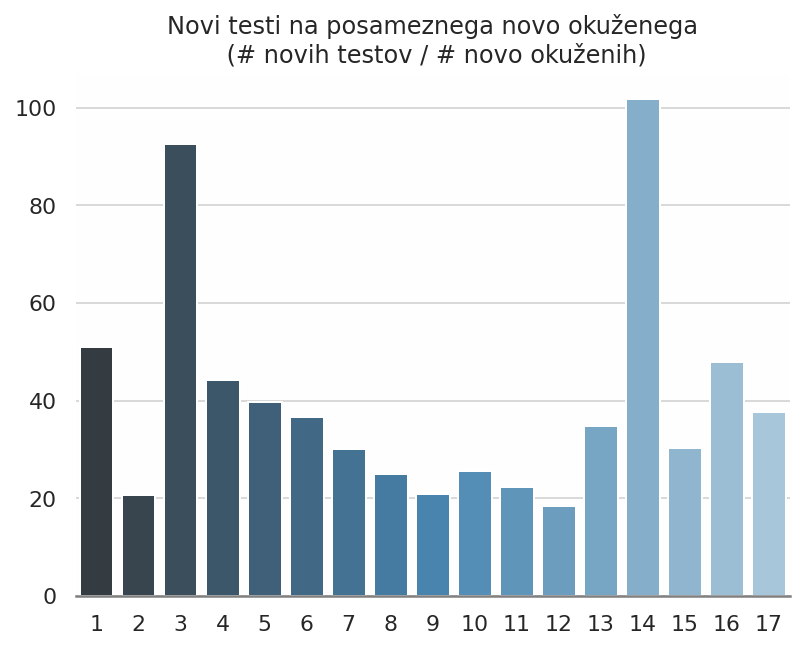

In [64]:
plot_bar(dni, novi_testi_na_novega, False, "Novi testi na posameznega novo okuženega\n (# novih testov / # novo okuženih)")

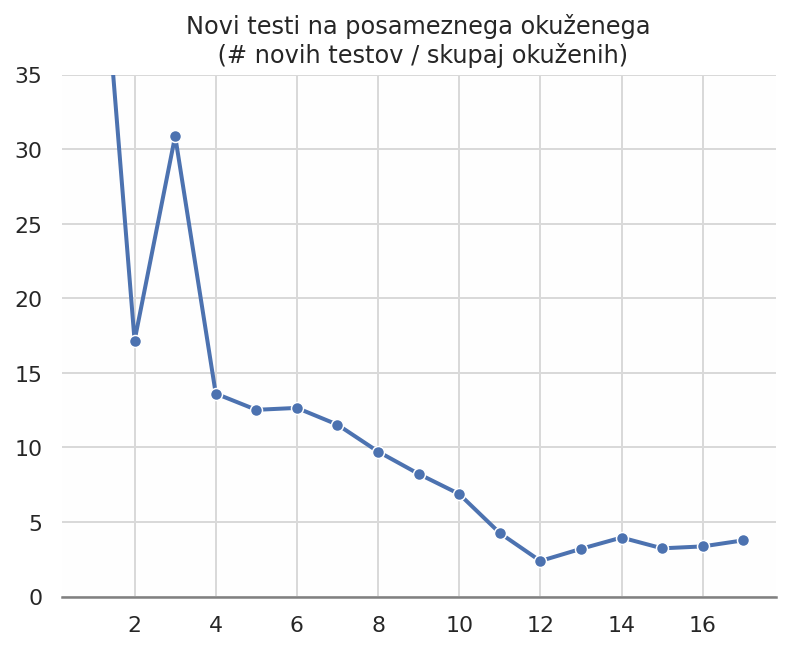

In [65]:
plot_line(dni, novi_testi_na_okuzenega, False, "Novi testi na posameznega okuženega\n (# novih testov / skupaj okuženih)",
          ylim=(0, 35))

---

%%latex
\newpage

# Pregled nad vsem skupaj

In [66]:
import pandas as pd

In [67]:
df = pd.DataFrame({"datum": [str(i+3) + ".3." for i in dni],
                   "okuzeni":okuzeni, "okuzeni novi":novi,
                  "testirani": testirani[4:], "testirani novi":novi_testi[3:]})

In [68]:
df

,datum,okuzeni,okuzeni novi,testirani,testirani novi
0,4.3.,1,1,364,51.0
1,5.3.,6,5,467,103.0
2,6.3.,9,3,745,278.0
3,7.3.,13,4,922,177.0
4,8.3.,19,6,1160,238.0
5,9.3.,29,10,1527,367.0
6,10.3.,47,18,2069,542.0
7,11.3.,77,30,2818,749.0
8,12.3.,127,50,3863,1045.0
9,13.3.,174,47,5060,1197.0


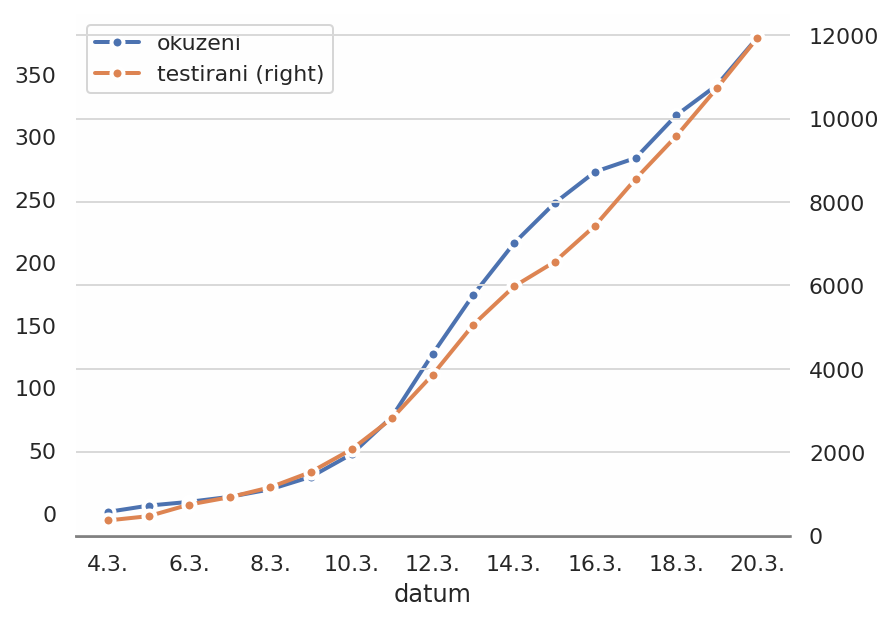

In [69]:
df[["datum", "okuzeni"]].plot("datum", legend=True)
df["testirani"].plot(legend=True, secondary_y=True)
#df["novi"].plot(legend=True)
#(df["novi"]/df["okuzeni"])[2:].plot(secondary_y=True, label="faktor rasti", legend=True)
plt.ylim(0)
plt.show()

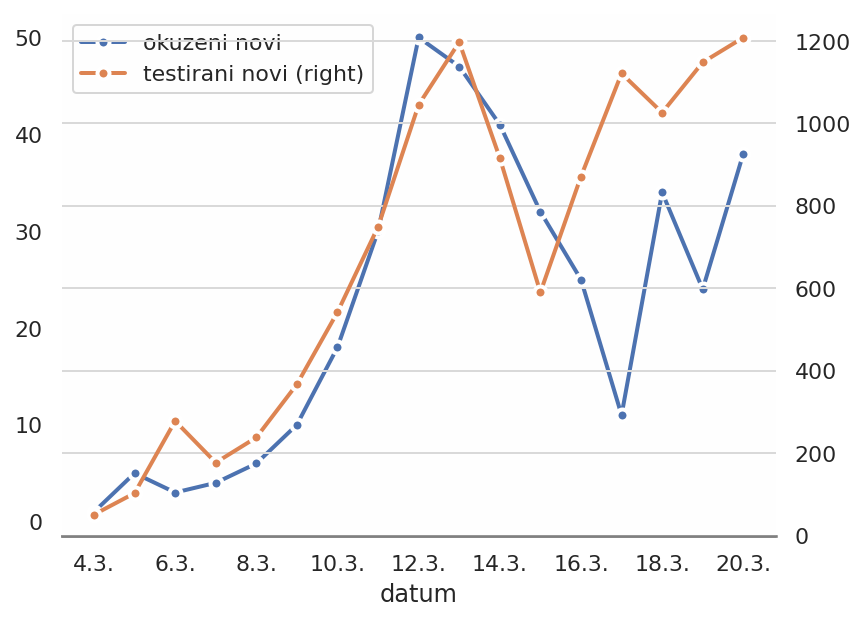

In [70]:
df[["datum", "okuzeni novi"]].plot("datum", legend=True)
df["testirani novi"].plot(legend=True, secondary_y=True)
plt.ylim(0)
plt.show()

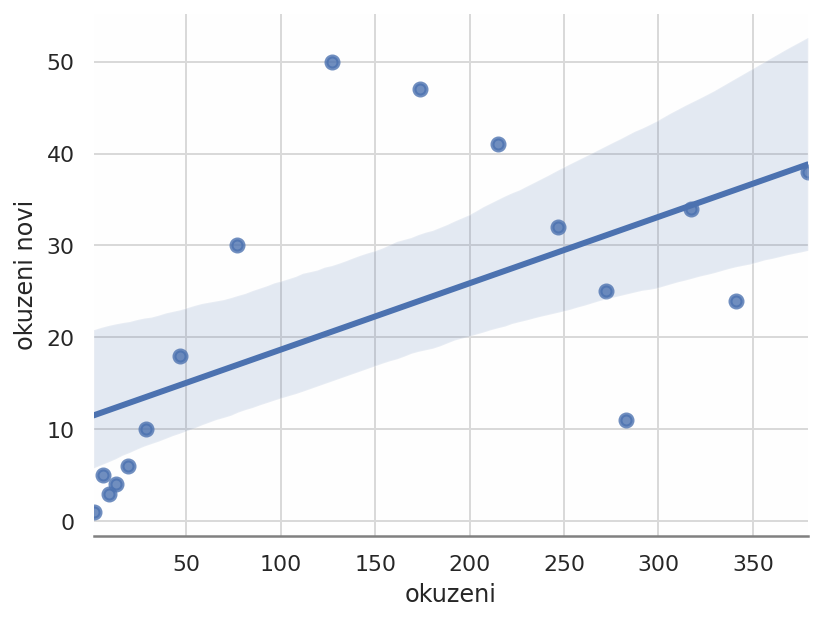

In [71]:
p = plt.rcParams["lines.marker"]
plt.rcParams["lines.marker"] = ""
sns.regplot(df["okuzeni"], df["okuzeni novi"])
plt.show()
plt.rcParams["lines.marker"] = p

---